# Style Transfer

In [96]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

import matplotlib.animation as animation
from IPython.display import display, HTML
from fastcore.test import *


from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [6]:
# Image URLs for demos. Change as desired.
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

In [7]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

content_im.shape: torch.Size([3, 256, 256])


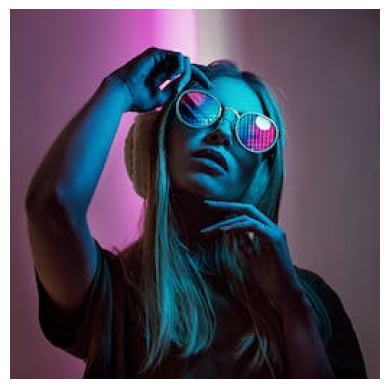

In [8]:
content_im = download_image(face_url).to(def_device)
print('content_im.shape:', content_im.shape)
show_image(content_im);


In [10]:
# Returns nothing however many times as length specified
# Useful when training with our ImageOptCB 
# as we are not using inputs or targets but a specific loss function instead
class LengthDataset():
    def __init__(self, length=1): fc.store_attr()
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100): # returns a data loader object with train and valid lengthdataset based data loaders
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                    DataLoader(LengthDataset(length), batch_size=1))

In [11]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

<Axes: >

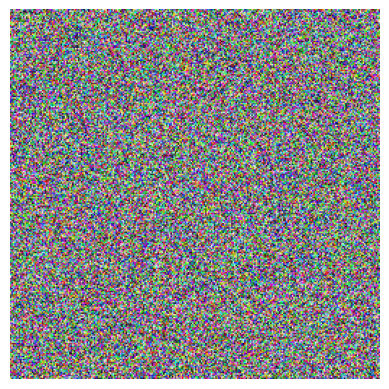

In [14]:
model = TensorModel(torch.rand_like(content_im)) # Creates a model with parameters for each channel x pixel of image
show_image(model())

In [15]:
[p.shape for p in model.parameters()]

[torch.Size([3, 256, 256])]

In [17]:
class ImageOptCB(TrainCB):
    def predice(self, learn): learn.preds = learn.model() # No inputs sent to model
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds) # loss with no targets

In [19]:
# Comparing directly to content image pixles across channels
# Should drive us to exatly the input image
def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

In [20]:
model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

loss,epoch,train
0.041,0,train
0.001,0,eval


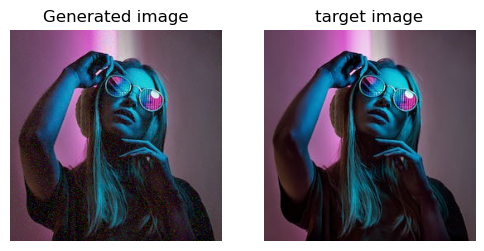

In [22]:

show_images([learn.model().clip(0,1), content_im], titles=["Generated image", "target image"])

In [43]:
class ImageLogEveryNStepsCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr(); self.images=[]; self.i=0
    def after_batch(self, learn): 
        print(len(learn.dls.train))
        if self.i%self.log_every == 0: self.images.append(to_cpu(learn.preds.clip(0, 1)))
        self.i += 1
    def after_fit(self, learn): 
        show_images(self.images)

In [52]:
class ImageLogNImages(Callback):
    order = ProgressCB.order + 1
    def __init__(self, n_images=6): 
        self.n_images = n_images 
        self.images=[]; 
        self.i=0
    def before_fit(self, learn):
        self.every = len(learn.dls.train) / self.n_images
    def after_batch(self, learn):
        if self.i%self.every == 0 and learn.training: self.images.append(to_cpu(learn.preds.clip(0, 1)))
        self.i += 1
    def after_fit(self, learn): 
        show_images(self.images)

loss,epoch,train
0.028,0,train
0.000,0,eval


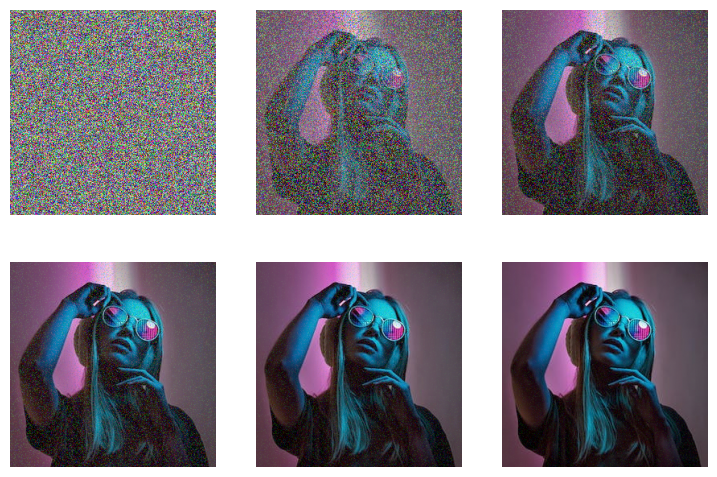

In [86]:
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
a = learn.fit(1, cbs=[ImageLogNImages()])

In [87]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

model.safetensors: 100%|██████████| 553M/553M [01:11<00:00, 7.70MB/s] 


In [88]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

In [89]:
def normalize(im):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:,None,None].to(im.device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:,None,None].to(im.device)
    return (im - imagenet_mean) / imagenet_std

In [90]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

In [93]:
normalize(content_im).mean(dim=(1, 2))


tensor([-0.9727, -0.9623, -0.4215], device='cuda:0')

In [100]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [99]:
# test_close(normalize(content_im), normalize2(content_im))